In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

import os
os.chdir(f"{path_prefix}")

from HiggsML.datasets import download_dataset

In [2]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-06-03 12:08:11,490 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-06-03 12:08:11,492 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-06-03 12:08:11,501 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-06-03 12:08:11,502 - HiggsML.datasets     - INFO     - Test size: 66029730


In [3]:
# Assign an integer with each of the processes (same as the dictionary used to load)
labels_dict = {"htautau": 0,
              "ztautau":1,
              "ttbar":2}

# exclude low stats diboson sample for now
# labels_dict = {"htautau": 0,
#               "ztautau":1,
#               "ttbar":2,
#               "diboson":3}


# np.save(f"{saved_data}labels_dictionary.npy", labels_dict)


In [4]:
list_of_processes = list(labels_dict.keys())

In [5]:
data.load_train_set(train_size=0.05)
df_training = data.get_train_set()

2025-06-03 12:08:17,547 - HiggsML.datasets     - INFO     - Selected train size: 7703468


KeyboardInterrupt: 

In [6]:
df_training['type'] = df_training['detailed_labels'].copy()

In [ ]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [ ]:
df_training.detailed_labels.unique()

array(['ztautau', 'htautau', 'ttbar'], dtype=object)

In [ ]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [ ]:
mask_selection = (df_training['PRI_lep_pt']<=250.0) & (df_training['PRI_met']<=250.0) & (df_training['PRI_had_pt']<=250.0)
df_training = df_training[mask_selection].copy()


In [45]:
syst_settings = {
    'TES_up': {'tes': 1.1},
    'TES_dn': {'tes': 0.9}
}

dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training,
        dopostprocess=True
        )

for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training, 
        dopostprocess=False, 
        **syst_args
    )



In [46]:
input_features = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()

In [47]:
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}cached_data/'


if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)


In [ ]:
for sample in dataset_dict: 
    dataset_dict[sample].to_hdf(f"{saved_data}df_{sample}.h5", key="dataset", mode="w")

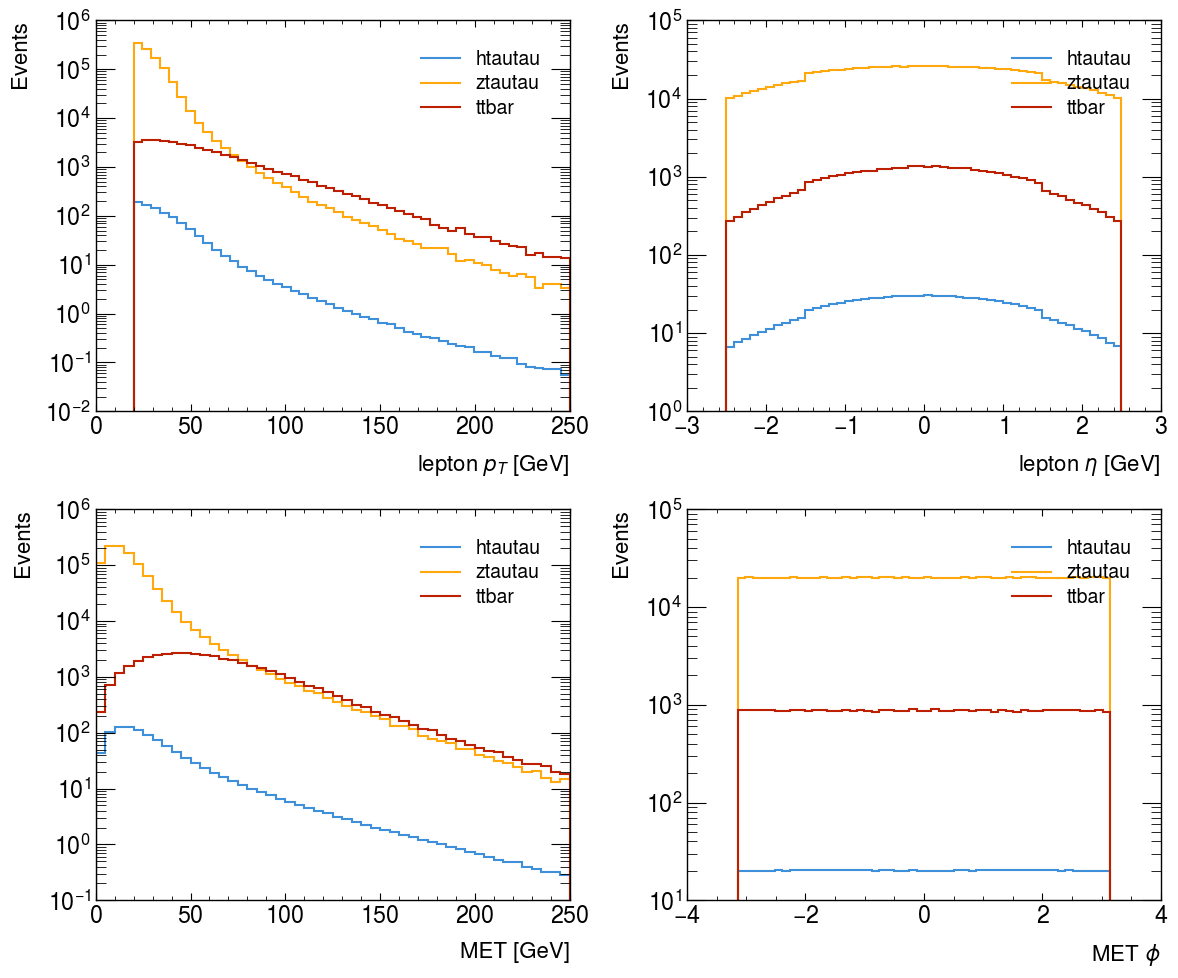

In [ ]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_n_jets']
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

bins_dict = {}
histograms = {}
for feature in columns:

    histograms[feature] = {}

    for count, label in enumerate(labels_dict):

        mask_process = (dataset_dict['nominal'].detailed_labels == label)

        feature_array = dataset_dict['nominal'][mask_process][feature].to_numpy()
        weights_array = dataset_dict['nominal'][mask_process]['weights'].to_numpy()

        if count==0:

            histograms[feature][label], bins = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=nbins
            )
        else:
            mask_process = (dataset_dict['nominal'].detailed_labels == label)
            histograms[feature][label], _ = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=bins
            )

    bins_dict[feature] = bins
            
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_label_map = {
    label: palette[i % len(palette)]
    for i,label in enumerate(labels_dict)
}

for count, feature in enumerate(columns):

    for label in labels_dict:

        hep.histplot(histograms[feature][label], bins=bins_dict[feature], label=label, 
                     ax=axes[count], linewidth=1.5, color=color_label_map[label])

    axes[count].set_yscale('log')
    axes[count].set_xlabel(xlabel_dict[feature], size=16)
    axes[count].set_ylabel('Events', size=16)
    axes[count].legend()

plt.tight_layout()
plt.show()


minimum of feature PRI_had_pt is 22.90999984741211


minimum of feature PRI_had_eta is -2.688999891281128
minimum of feature PRI_had_phi is -3.1419999599456787
minimum of feature PRI_jet_leading_pt is -25.0


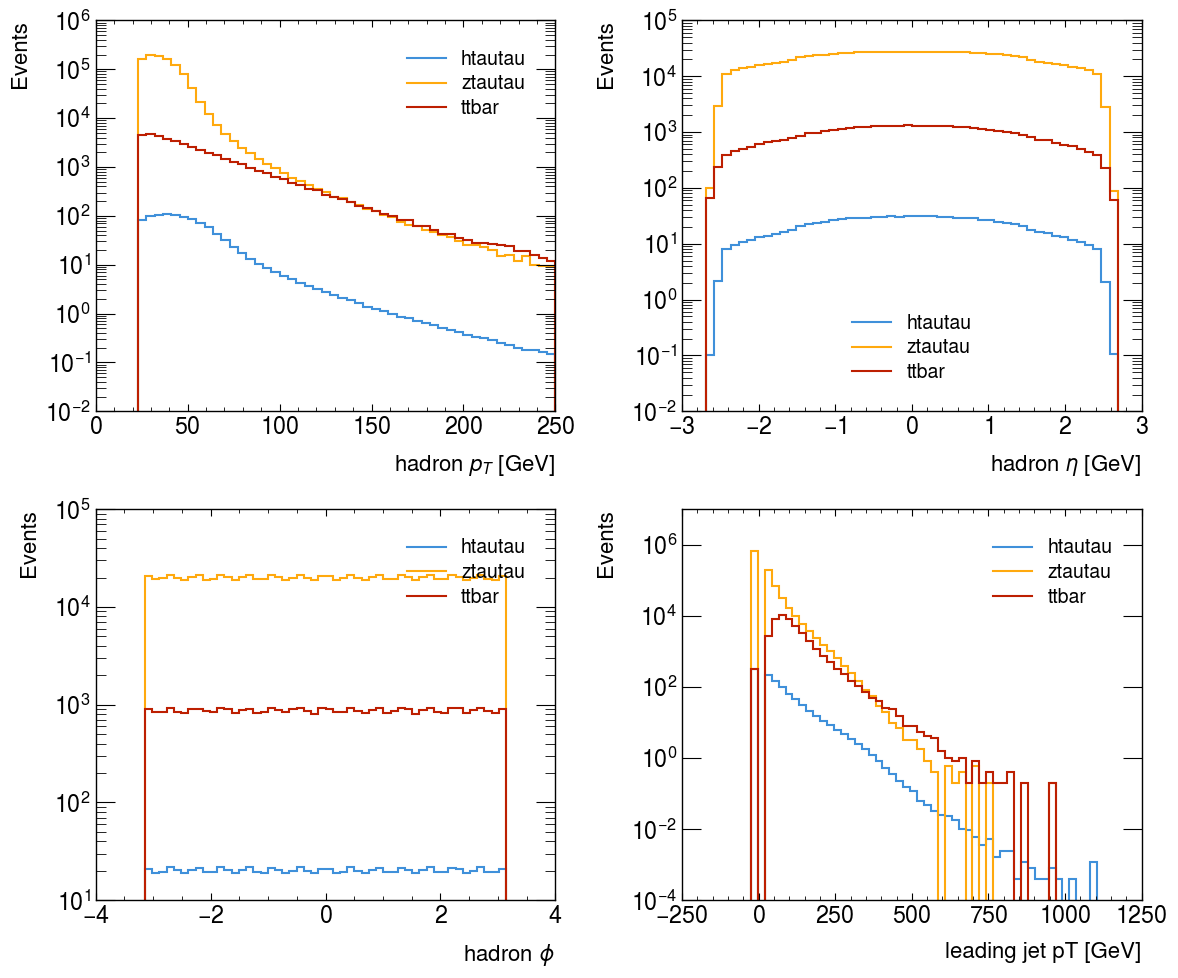

In [ ]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_leading_pt']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_leading_pt': 'leading jet pT [GeV]',
}

bins_dict = {}
histograms = {}
for feature in columns:

    histograms[feature] = {}

    for count, label in enumerate(labels_dict):

        mask_process = (dataset_dict['nominal'].detailed_labels == label)

        feature_array = dataset_dict['nominal'][mask_process][feature].to_numpy()
        if count==0:
            print(f"minimum of feature {feature} is {np.amin(feature_array)}")
        weights_array = dataset_dict['nominal'][mask_process]['weights'].to_numpy()

        if count==0:

            histograms[feature][label], bins = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=nbins
            )
        else:
            mask_process = (dataset_dict['nominal'].detailed_labels == label)
            histograms[feature][label], _ = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=bins
            )

    bins_dict[feature] = bins
            
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_label_map = {
    label: palette[i % len(palette)]
    for i,label in enumerate(labels_dict)
}

for count, feature in enumerate(columns):

    for label in labels_dict:

        hep.histplot(histograms[feature][label], bins=bins_dict[feature], label=label, 
                     ax=axes[count], linewidth=1.5, color=color_label_map[label])

    axes[count].set_yscale('log')
    axes[count].set_xlabel(xlabel_dict[feature], size=16)
    axes[count].set_ylabel('Events', size=16)
    axes[count].legend()

plt.tight_layout()
plt.show()
